# Semantic segmentation with deep learning
> A guide for using deep-learning based semantic segmentation to land use / land cover in satellite imagery.

In this tutorial we will learn how to segment images according to a set of classes. **Segmentation**  refers to the process of partitioning an image into groups of pixels that identify with a target class within the foreground or the background class (a catch-all class that contains non-target features).

Specifically, in this tutorial we will be using data from a [fusion dataset for crop type classification in Germany](https://mlhub.earth/data/dlr_fusion_competition_germany). It leverages Planet 5 day composites and polygon labels.

Our task will be to predict the crop types (a form of land use / land cover) in an image on a pixel-wise basis. 

## Specific concepts that will be covered
In the process, we will build practical experience and develop intuition around the following concepts:
* **[Functional API](https://keras.io/getting-started/functional-api-guide/)** - we will be implementing UNet, a convolutional network model classically used for biomedical image segmentation with the Functional API. 
  * This model has layers that require multiple input/outputs. This requires the use of the functional API
  * Check out the original [paper](https://arxiv.org/abs/1505.04597), 
U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger!
* **Loss Functions and Metrics** - We'll implement the **Sparse Categorical [focal loss](https://focal-loss.readthedocs.io/en/latest/) function**
 and **accuracy**. We'll also generate confusion matrices during evaluation to judge how well the model performs. 
* **Saving and loading Keras models** - We'll save our best model to file. When we want to perform inference/evaluate our model in the future, we can load the model file. 

### General Workflow
1. Load image and label datasets (acquired and processed in the prior lesson) from Google Drive
2. Visualize data/perform some exploratory data analysis
3. Set up data pipeline and preprocessing
4. Build model
5. Train model
6. Test model

### Objectives
1. Practice with the Keras Functional API as a means to run TensorFlow models
2. Experience training a segmentation model and monitoring progress
3. Learn how to generate predictions with a trained segmentation model


**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. 

**Time Estimated**: 60-120 min



## Setup Notebook

```{admonition} **Version control**
Colab updates without warning to users, which can cause notebooks to break. Therefore, we are pinning library versions.
``` 

In [ ]:
!python --version

In [ ]:
!pip --version

In [ ]:
!pip install pip==21.1.3

In [ ]:
# install required libraries
!pip install -q rasterio==1.2.10
!pip install -q geopandas==0.10.2
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly
!pip install -q focal-loss
!pip install -q tensorflow-addons==0.8.3
#!pip install -q matplotlib==3.5 # UNCOMMENT if running on LOCAL
!pip install -q scikit-learn==1.0.1
!pip install -q scikit-image==0.18.3
!pip install -q tf-explain==0.3.1
!pip install -q segmentation_models # we'll use this for pretraining later and for the IOU segmentation performance metric

In [2]:
# import required libraries
import os, glob, functools, fnmatch, io, shutil
from zipfile import ZipFile
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features, mask

import geopandas as gpd

import tensorflow as tf
from tensorflow.python.keras import layers, losses, models
from tensorflow.python.keras import backend as K  
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

from tensorflow_examples.models.pix2pix import pix2pix
from segmentation_models.metrics import iou_score
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
from time import sleep
from tqdm.notebook import tqdm
import datetime

from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import confusion_matrix, f1_score
import skimage.io as skio

Segmentation Models: using `keras` framework.


#### Getting set up with the data

```{important}
The tiled imagery is available at the following path that is accessible with the google.colab `drive` module: `'/content/gdrive/My Drive/tf-eo-devseed/'`
```

We'll be working with the following folders and files in the `tf-eo-devseed` folder:
```
tf-eo-devseed/
├── stacks/
├── stacks_brightened/
├── indices/
├── labels/
├── background_list_train.txt
├── train_list_clean.txt
└── lulc_classes.csv
```

In [3]:
# set your root directory and tiled data folders
if 'google.colab' in str(get_ipython()):
    # this is a google colab specific command to ensure TF version 2 is used. 
    # it won't work in a regular jupyter notebook, for a regular notebook make sure you install TF version 2
    %tensorflow_version 2.x
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/tf-eo-devseed/' 
    workshop_dir = '/content/gdrive/My Drive/tf-eo-devseed-workshop'
    dirs = [root_dir, workshop_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/tf-eo-devseed")
    workshop_dir = os.path.abspath('./tf-eo-devseed-workshop')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')

img_dir = os.path.join(root_dir,'rasters/tiled/stacks_brightened/') # or os.path.join(root_dir,'rasters/tiled/indices/') if using the indices
label_dir = os.path.join(root_dir,'rasters/tiled/labels/')

Mounted at /content/gdrive
Running on Colab


In [4]:
# go to root directory
%cd $root_dir 

/content/gdrive/My Drive/tf-eo-devseed


### Enabling GPU

This notebook can utilize a GPU and works better if you use one. Hopefully this notebook is using a GPU, and we can check with the following code.

If it's not using a GPU you can change your session/notebook to use a GPU. See [Instructions](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

### Check out the labels

Class names and identifiers extracted from the documentation provided here: https://radiantearth.blob.core.windows.net/mlhub/esa-food-security-challenge/Crops_GT_Brandenburg_Doc.pdf

In [5]:
# Read the classes

data = {'class_names':  ['Background', 'Wheat', 'Rye', 'Barley', 'Oats', 'Corn', 'Oil Seeds', 'Root Crops', 'Meadows', 'Forage Crops'],
        'class_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        }

classes = pd.DataFrame(data)
print(classes) 


    class_names  class_ids
0    Background          0
1         Wheat          1
2           Rye          2
3        Barley          3
4          Oats          4
5          Corn          5
6     Oil Seeds          6
7    Root Crops          7
8       Meadows          8
9  Forage Crops          9


### Read into tensorflow datasets

Now we will compile the spectral index image and label tiles into training, validation, and test datasets for use with TensorFlow.


Get lists of image and label tile pairs for training and testing.
<div>&#8681</div> 




In [ ]:
def get_train_test_lists(imdir, lbldir):
  imgs = glob.glob(os.path.join(imdir,"*.png"))
  #print(imgs[0:1])
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)

  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))

  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames

train_list, x_train_filenames, y_train_filenames = get_train_test_lists(img_dir, label_dir)

Check for the proportion of background tiles. This takes a while. So after running this once, you can skip by loading from saved results.
<div>&#8681</div> 

In [ ]:
skip = False

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      # print(os.path.join(label_dir,"{}.png".format(i))) 
      img = np.array(Image.open(os.path.join(label_dir,"{}.png".format(i))))  
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)

  print("Number of background images: ", len(background_list_train))

  with open(os.path.join(root_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("Number of background images: ", len(background_list_train))

We will keep only 10% of the total. Too many background tiles can cause a form of class imbalance.
<div>&#8681</div> 

In [ ]:
background_removal = len(background_list_train) * 0.9
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []

for i, img_id in zip(tqdm(range(len(train_list_clean))), train_list_clean):
  pass 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))

print("Number of background tiles: ", background_removal)
print("Remaining number of tiles after 90% background removal: ", len(train_list_clean))

Now that we have our set of files we want to use for developing our model, we need to split them into three sets: 
* the training set for the model to learn from
* the validation set that allows us to evaluate models and make decisions to change models
* and the test set that we will use to communicate the results of the best performing model (as determined by the validation set)

We will split index tiles and label tiles into train, validation and test sets: 70%, 20% and 10%, respectively.

In [ ]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.3, random_state=42)
x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames = train_test_split(x_val_filenames, y_val_filenames, test_size=0.33, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

```{warning} **Long running cell** \
The code below checks for values in train, val, and test partitions. 
```


In [ ]:
vals_train = []
vals_val = []
vals_test = []

def get_vals_in_partition(partition_list, x_filenames, y_filenames):
  for x,y,i in zip(x_filenames, y_filenames, tqdm(range(len(y_filenames)))):
      pass 
      try:
        img = np.array(Image.open(y)) 
        vals = np.unique(img)
        partition_list.append(vals)
      except:
        continue

def flatten(partition_list):
    return [item for sublist in partition_list for item in sublist]

get_vals_in_partition(vals_train, x_train_filenames, y_train_filenames)
get_vals_in_partition(vals_val, x_val_filenames, y_val_filenames)
get_vals_in_partition(vals_test, x_test_filenames, y_test_filenames)

In [11]:
print("Values in training partition: ", set(flatten(vals_train)))
print("Values in validation partition: ", set(flatten(vals_val)))
print("Values in test partition: ", set(flatten(vals_test)))

Values in training partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Values in validation partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Values in test partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### Visualize the data

```{warning} **Long running cell** \
The code below loads foreground examples randomly. 
```
<div>&#8681</div> 

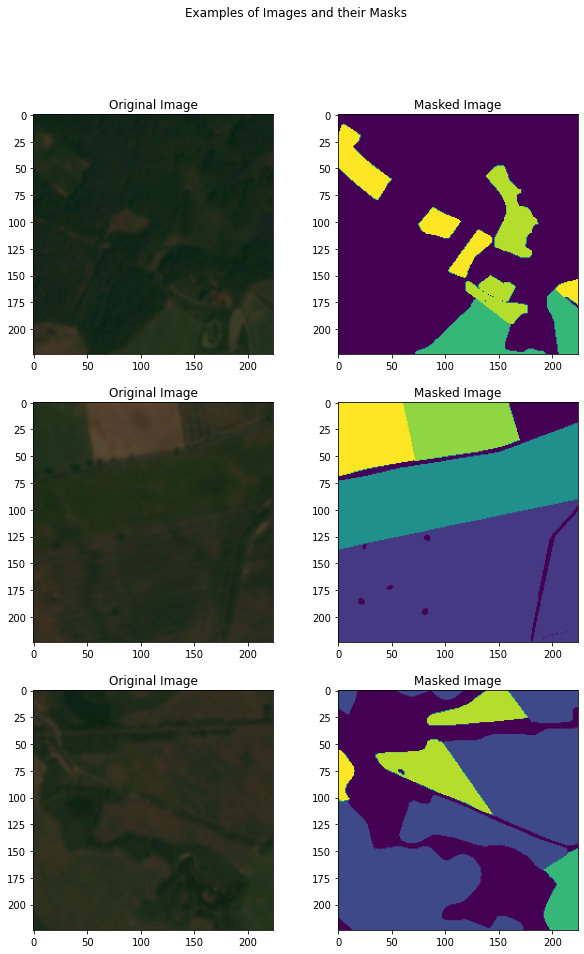

In [12]:
display_num = 3

background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]

# select only for tiles with foreground labels present
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    try:
      filename_split = os.path.splitext(y) 
      filename_zero, fileext = filename_split 
      basename = os.path.basename(filename_zero) 
      if basename not in background_list_train:
        foreground_list_x.append(x)
        foreground_list_y.append(y)
      else:
        continue
    except:
      continue

num_foreground_examples = len(foreground_list_y)

# randomlize the choice of image and label pairs
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  img_num = i // 2
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

### Read the tiles into tensors

In [13]:
# set input image shape
img_shape = (224, 224, 3)
# set batch size for model
batch_size = 8

In [14]:
# Function for reading the tiles into TensorFlow tensors 
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  # The label image should have any values between 0 and 8, indicating pixel wise
  # foreground class or background (0). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [15]:
# Function to augment the data with horizontal flip
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [16]:
# Function to augment the data with vertical flip
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [17]:
# Function to augment the images and labels
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=None,  # Scale image e.g. 1 / 255.
             horizontal_flip=False,
             vertical_flip=False): 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize(label_img, resize)
    img = tf.image.resize(img, resize)
  
  img, label_img = flip_img_h(horizontal_flip, img, label_img)
  img, label_img = flip_img_v(vertical_flip, img, label_img)
  img = tf.cast(img, tf.float32) 
  if scale is not None:
    img = tf.cast(img, tf.float32) * scale
    #img = tf.keras.layers.Rescaling(scale=scale, offset=-1)
  #label_img = tf.cast(label_img, tf.float32) * scale
  #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
  return img, label_img

In [18]:
# Main function to tie all of the above four dataset processing functions together 
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [19]:
# dataset configuration for training
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [20]:
# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [21]:
# dataset configuration for testing
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)

In [22]:
# create the TensorFlow datasets
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)
test_ds = get_baseline_dataset(x_test_filenames,
                              y_test_filenames, 
                              preproc_fn=test_preprocessing_fn,
                              batch_size=batch_size)

In [23]:
# Now we will display some samples from the datasets
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

In [24]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

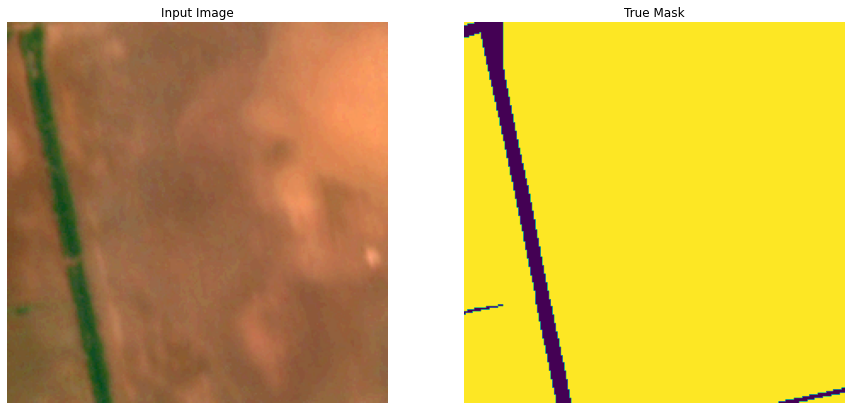

In [25]:
# display sample train image
display([sample_image, sample_mask])

...same check for the validation images:

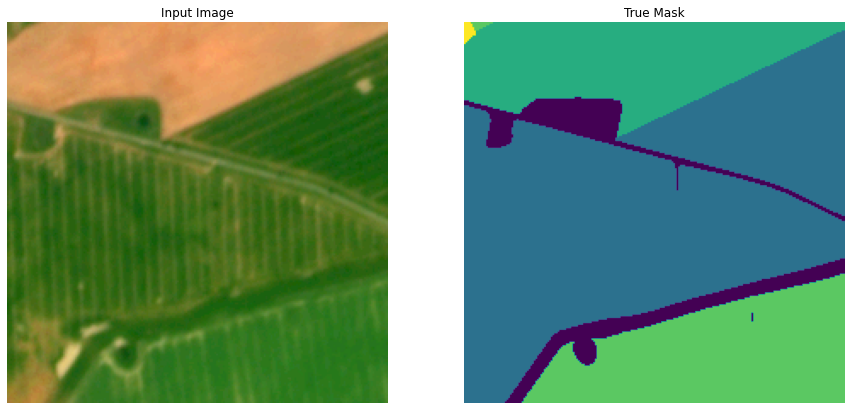

In [26]:
# reset the forground list to capture the validation images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_val_filenames, y_val_filenames): 
    try:
      filename_split = os.path.splitext(y) 
      filename_zero, fileext = filename_split 
      basename = os.path.basename(filename_zero) 
      if basename not in background_list_train:
        foreground_list_x.append(x)
        foreground_list_y.append(y)
      else:
        continue
    except:
      continue

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=val_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample validation image
display([sample_image, sample_mask])

...same check for the test images:


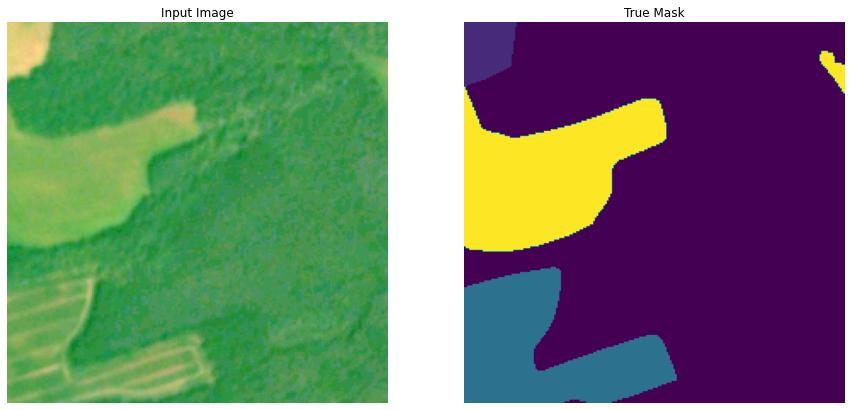

In [30]:
# reset the forground list to capture the test images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_test_filenames, y_test_filenames): 
    try:
      filename_split = os.path.splitext(y) 
      filename_zero, fileext = filename_split 
      basename = os.path.basename(filename_zero) 
      if basename not in background_list_train:
        foreground_list_x.append(x)
        foreground_list_y.append(y)
      else:
        continue
    except:
      continue

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample test image
display([sample_image, sample_mask])

### Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, an optionally pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

:::{figure-md} Unet_mobilenetv2_arch_arch-fig

<img src="https://github.com/developmentseed/servir-amazonia-ml/blob/main/ds_book/docs/images/Unet_mobilenetv2_arch_arch.png?raw=1" width="650px">

U-shaped MobileNetV2 (adapted U-Net) architecture diagram (from [Sarakon et al., 2019](https://www.researchgate.net/publication/339266308_Surface-Defect_Segmentation_using_U-shaped_Inverted_Residuals)). 
:::

The reason to output nine channels is because there are nine possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into nine classes.

In [31]:
# set number of model output channels to the number of classes (including background)
OUTPUT_CHANNELS = 10 

As mentioned, the encoder will be an optionally pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will be trained during the training process, as it would necessitate optical imagery if transfer learning were to be used, and in this example we are using spectral indices.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu', 
    'block_13_expand_relu',
    'block_16_project', 
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True # Set this to False if using pre-trained weights

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples. The arguments are (number of filters, kernel size). A kernel size of 3 is considered standard for current network implementations ([Sandler et al., 2018](https://arxiv.org/abs/1801.04381)). You can increase or decrease the number of filters, however, more filters equates to more parameters and longer training time. A range between 32 to 512, increasing 2x for each successive convolutional layer and decreasing for each successive deconvolutional/upsampling layer, is very common across different convolutional network architectures.

In [33]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [34]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224,224,3], name='first_layer')
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', name='last_layer')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model

Now, all that is left to do is to compile and train the model. The loss being used here is SparseCategoricalFocalLoss(from_logits=True). The reason to use this loss function is 1) because the network is trying to assign each pixel a label, just like multi-class prediction, and 2) because focal loss weights the relative contribution of each class by the distribution in the dataset to emphasize under-represented classes and dampen over-represented classes. In the true segmentation mask, each pixel has a value between 0-10. The network here is outputting ten channels. Essentially, each channel is trying to learn to predict a class, and SparseCategoricalFocalLoss(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [35]:
model = unet_model(OUTPUT_CHANNELS)

Check the network layer output shapes

In [ ]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

Find the class weights for the focal loss function to help address class imbalance.

In [ ]:
train_df = gpd.read_file('dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')
inv_freq = np.array(1/(train_df.crop_id.value_counts()/len(train_df)))
inv_freq = [0.,*inv_freq]
class_weights = {0 : inv_freq[0], 1: inv_freq[1], 2: inv_freq[2], 3: inv_freq[3], 
                4: inv_freq[4], 5: inv_freq[5], 6: inv_freq[6],
                7: inv_freq[7], 8: inv_freq[8], 9: inv_freq[9]}

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

class_weights_list = list(class_weights.values())
print("class weights: ", class_weights_list)
scaled_class_weights = NormalizeData(class_weights_list)
scaled_class_weights_list = scaled_class_weights.tolist() 
print("scaled class weights: ", scaled_class_weights_list)

In the SparseCategoricalFocalLoss function, gamma is the focusing parameter. Higher values of gamma make dominant, or "easy to classify", examples contribute less to the loss relative to rare, or "difficult to classify", examples. The value for gamma must be non-negative, and the authors of this loss function found that empirically a gamma value of 2 works best ([Lin et al., 2017](https://arxiv.org/abs/1708.02002)). You can experiment by adding the class weights as a parameter to SparseCategoricalFocalLoss, e.g. `SparseCategoricalFocalLoss(gamma=2, class_weight=scaled_class_weights_list, from_logits=True)`.

We will measure our model's performance during training by per-pixel accuracy.


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True), #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', iou_score])

Let's try out the un/pre-trained model to see what it predicts before training.

In [39]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [40]:
def show_predictions(image=None, mask=None, dataset=None, num=1):
  if image is None and dataset is None:
    # this is just for showing keras callback output. in practice this should be broken out into a different function
    sample_image = skio.imread(f'{img_dir}/tile_dlr_fusion_competition_germany_train_source_planet_5day_33N_18E_242N_2018_05_28_811.png') * (1/255.)
    sample_mask = skio.imread(f'{label_dir}/tile_dlr_fusion_competition_germany_train_source_planet_5day_33N_18E_242N_2018_05_28_811.png')
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask[..., tf.newaxis], mpe])
  elif dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([image, mask, mpe])

In [ ]:
show_predictions(image=sample_image, mask=sample_mask)

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below to plot a test image and its predicted mask after each epoch.

In [42]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

We may want to view the model graph and training progress in TensorBoard, so we'll establish a callback to save logs to a dedicated directory which will serve the TensorBoard interface.

In [43]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir = os.path.join(workshop_dir,'logs/')
log_fit_dir = os.path.join(workshop_dir,'logs', 'fit')
log_fit_session_dir = os.path.join(workshop_dir,'logs', 'fit', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
visualizations_dir = os.path.join(workshop_dir,'logs', 'vizualizations')
visualizations_session_dir = os.path.join(workshop_dir,'logs', 'vizualizations', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

dirs = [log_fit_dir, visualizations_dir]
for dir in dirs:
  if (os.path.isdir(dir)):
    print("Making fresh log dir.")
    shutil.rmtree(dir)
  else:
    print("Fresh log dir exists.")

dirs = [log_dir, log_fit_dir, log_fit_session_dir, visualizations_dir, visualizations_session_dir]
for dir in dirs:
  if (not os.path.isdir(dir)):
    os.mkdir(dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_fit_session_dir, histogram_freq=1, write_graph=True)

We can also take a look at the layer activations in TensorBoard using tf-explain, so we'll establish a callback to save activation visualizations to a dedicated directory which will serve the TensorBoard interface.

In [45]:
# get a batch of validation samples to plot activations for
for example in val_ds.take(1):
  image_val, label_val = example[0], example[1]

In [46]:
callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(image_val, label_val),
        layers_name=["last_layer"], 
        output_dir=visualizations_session_dir,
    ),
    DisplayCallback(),
    tensorboard_callback
]

#### Fit and View
Now we will actually train the model for 4 epochs (full cycles through the training dataset), visualizing predictions on a validation image after each epoch. In practice, you would want to train the model until validation loss starts to increase (a clear indication of overfitting). Empirically with this dataset, convergence occurred around 50 epochs. We've reduced to 4 epochs purely for rapid demonstration purposes. As a preview, at 50 epochs you should observe a test prediction similar to:

![testimage](images/epoch50_testimage.png)

Don't be alarmed if you see blank predictions after only 4 epochs.

In [ ]:
EPOCHS = 4

model_history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=callbacks) 

Plot the model's learning curve over time.

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#### Start TensorBoard 

You set the `logdir` in the below command to `..logs/visualizations` to see the activations or `..logs/fit` to see the model scalars, graphs, distributions and histograms (described below).

The dashboards can be selected from the tabs in top navigation bar.

1. The Scalars dashboard shows how the loss and metrics change with every  epoch. You can use it to also track training speed, learning rate, and other scalar values.
2. The Graphs dashboard helps you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly.
3. The Distributions and Histograms dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.

In [ ]:
%tensorboard --logdir "$visualizations_dir"

---------------------------------

#### Save model to file

We will export the final model weights to your own google drive folder.

In [ ]:
if (not os.path.isdir(workshop_dir)):
  os.mkdir(workshop_dir)
save_model_path = os.path.join(workshop_dir,'model_out_batch_{}_ep{}_nopretrain_focalloss/'.format(batch_size, EPOCHS))
if (not os.path.isdir(save_model_path)):
  os.mkdir(save_model_path)
model.save(save_model_path)

### Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results. We'll load from the rea donly workshop directory in case you weren't able to save your own model.

In [51]:
# Optional, you can load the model from the saved version
load_from_checkpoint = True
if load_from_checkpoint == True:
  save_model_path = os.path.join(workshop_dir,'model_out_batch_{}_ep{}_nopretrain_focalloss/'.format(batch_size, EPOCHS))
  model = tf.keras.models.load_model(save_model_path, custom_objects={"loss": SparseCategoricalFocalLoss, "iou_score": iou_score})
else:
  print("inferencing from in memory model")

In [52]:
def get_predictions(image= None, dataset=None, num=1):
  if image is None and dataset is None:
    return ValueError("At least one of image or dataset must not be None.")
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      return pred_mask
  else:
    pred_mask = create_mask(model.predict(image[tf.newaxis, ...]))
    pred_mask = tf.keras.backend.eval(pred_mask)
    return pred_mask

#### Single image example

In [ ]:
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# run and plot predicitions
pred_mask = get_predictions(sample_image)

show_predictions(image=sample_image, mask=sample_mask)

#### Multi image example

In [ ]:
tiled_prediction_dir = os.path.join(workshop_dir,'predictions_test_focal_loss/')
if not os.path.exists(tiled_prediction_dir):
    os.makedirs(tiled_prediction_dir)
    
pred_masks = []
pred_paths = []
true_masks = []

for i in range(0, len(x_test_filenames)):
    img_num = i

    try:
      temp_ds = get_baseline_dataset(x_test_filenames[img_num:img_num+1], 
                                   y_test_filenames[img_num:img_num+1],
                                   preproc_fn=test_preprocessing_fn,
                                   batch_size=1,
                                   shuffle=False)
    except Exception as e: 
      print(str(e))

    # Let's examine some of these augmented images

    iterator = iter(temp_ds)
    next_element = iterator.get_next()

    batch_of_imgs, label = next_element

    # Running next element in our graph will produce a batch of images
    image, mask = batch_of_imgs[0], label[0,:,:,:]
    mask_int = tf.dtypes.cast(mask, tf.int32)
    true_masks.append(mask_int)
    print(y_test_filenames[img_num:img_num+1])
    print(np.unique(mask_int))

    # run and plot predicitions, only showing every 27th prediction
    #if img_num % 27 == 0:
    #    show_predictions(image=image, mask=mask)
    show_predictions(image=image, mask=mask)
    pred_mask = get_predictions(image)
    pred_masks.append(pred_mask)
    
    # save prediction images to file

    filename_split = os.path.splitext(x_test_filenames[img_num]) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    pred_path = os.path.join(tiled_prediction_dir, "{}.png".format(basename))
    pred_paths.append(pred_path)
    tf.keras.preprocessing.image.save_img(pred_path,pred_mask, scale=False) # scaling is good to do to cut down on file size, but adds an extra dtype conversion step.    

Finally, we will save a csv with our test file paths so we can easily load predictions and labels in the next lesson to calculate our evaluation metrics.

In [56]:
path_df = pd.DataFrame(list(zip(x_test_filenames, y_test_filenames, pred_paths)), columns=["img_names", "label_names", "pred_names"])
path_df.to_csv(os.path.join(workshop_dir, "test_file_paths.csv"))

path_df = pd.DataFrame(list(zip(x_train_filenames, y_train_filenames)), columns=["img_names", "label_names"])
path_df.to_csv(os.path.join(workshop_dir, "train_file_paths.csv"))

path_df = pd.DataFrame(list(zip(x_val_filenames, y_val_filenames)), columns=["img_names", "label_names"])
path_df.to_csv(os.path.join(workshop_dir, "validate_file_paths.csv"))